In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from keras.layers import Flatten
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from keras.preprocessing.image import ImageDataGenerator
# Imports for testing pretrained models
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input as ppi_resnet
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as ppi_vgg
# Import metrics
from sklearn.metrics import classification_report, confusion_matrix
# Import plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


from flask import Flask, jsonify, request
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image



import os

In [2]:
# ResNet50 data augmentation

resnet50_datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=.2,
    preprocessing_function=ppi_resnet
) 

train_generator_resnet50 = resnet50_datagen.flow_from_directory(
    directory='data/train',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True,
)
val_generator_resnet50 = resnet50_datagen.flow_from_directory(
    directory='data/train',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=True,
)



Found 216 images belonging to 3 classes.
Found 54 images belonging to 3 classes.


In [3]:
# Again - the same preprocessing function must be applied to the test set
test_gen = ImageDataGenerator(
    preprocessing_function=ppi_resnet
    )
test_gen = test_gen.flow_from_directory('data/valid', target_size=(224, 224), class_mode='categorical', shuffle=False)


Found 15 images belonging to 3 classes.


In [ ]:
# Modelling ResNet

resnet50 = ResNet50(include_top = False, input_shape = (224,224,3), weights = 'imagenet')

for layer in resnet50.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(resnet50.output)
predictions = Dense(3, activation='softmax')(x)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_resnet50 = Model(inputs = resnet50.input, outputs = predictions)
model_resnet50.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

callbacks=[tf.keras.callbacks.CSVLogger('history_resnet50.csv')]
history_resnet50 = model_resnet50.fit(
      train_generator_resnet50,
      validation_data=val_generator_resnet50,
      epochs=20,
      verbose=2,
      callbacks=callbacks)


Epoch 1/20
7/7 - 32s - loss: 0.9692 - accuracy: 0.5509 - val_loss: 0.5658 - val_accuracy: 0.7778 - 32s/epoch - 5s/step
Epoch 2/20
7/7 - 26s - loss: 0.5217 - accuracy: 0.8102 - val_loss: 0.3428 - val_accuracy: 0.8889 - 26s/epoch - 4s/step
Epoch 3/20
7/7 - 28s - loss: 0.3357 - accuracy: 0.8796 - val_loss: 0.2464 - val_accuracy: 0.9259 - 28s/epoch - 4s/step
Epoch 4/20
7/7 - 26s - loss: 0.2936 - accuracy: 0.8981 - val_loss: 0.3332 - val_accuracy: 0.9074 - 26s/epoch - 4s/step
Epoch 5/20
7/7 - 25s - loss: 0.2385 - accuracy: 0.9259 - val_loss: 0.1502 - val_accuracy: 0.9630 - 25s/epoch - 4s/step
Epoch 6/20
7/7 - 24s - loss: 0.2200 - accuracy: 0.9213 - val_loss: 0.1898 - val_accuracy: 0.9444 - 24s/epoch - 3s/step
Epoch 7/20
7/7 - 24s - loss: 0.2013 - accuracy: 0.9213 - val_loss: 0.2709 - val_accuracy: 0.9074 - 24s/epoch - 3s/step
Epoch 8/20
7/7 - 24s - loss: 0.1959 - accuracy: 0.9398 - val_loss: 0.2504 - val_accuracy: 0.8889 - 24s/epoch - 3s/step
Epoch 9/20
7/7 - 25s - loss: 0.1704 - accuracy: 

In [5]:
print(len(model_resnet50.non_trainable_weights))
print(len(model_resnet50.trainable_weights))

318
2


In [6]:
model_resnet50.evaluate(test_gen)


1/1 [==============================] - 1s 1s/step - loss: 0.5300 - accuracy: 0.8000


[0.5299937725067139, 0.800000011920929]

In [7]:
# Save model to my drive
file_name = '../job project/history_resnet50.h5'
config =model_resnet50.save(file_name)


In [8]:
model_history = pd.DataFrame()
df = pd.read_csv('../job project/history_resnet50.csv')
history_resnet50 = pd.concat([model_history, df] , axis=1)
name = 'history_resnet50'
history_resnet50.to_csv(name)
model_history = pd.read_csv('../job project/history_resnet50.csv')
model_history .head(3)


,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.513889,0.932700,0.888889,0.493553
1,1,0.847222,0.441155,0.944444,0.346873
2,2,0.888889,0.312864,0.925926,0.216111


In [9]:
predictions = model_resnet50.predict(test_gen)
y_true = test_gen.labels
y_pred = np.array([np.argmax(predictions[i]) for i in range(predictions.shape[0])])
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))



1/1 [==============================] - 4s 4s/step
[[5 0 0]
 [0 5 0]
 [3 0 2]]
              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      1.00      1.00         5
           2       1.00      0.40      0.57         5

    accuracy                           0.80        15
   macro avg       0.88      0.80      0.78        15
weighted avg       0.88      0.80      0.78        15



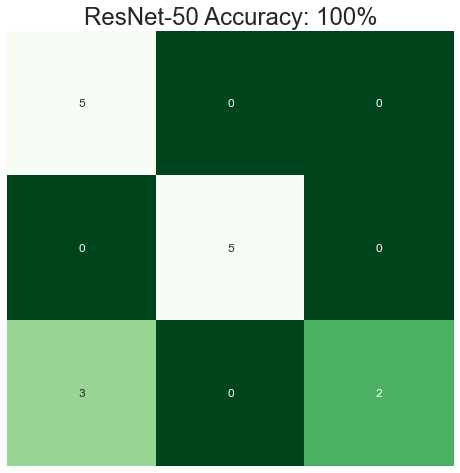

In [10]:
sns.set(rc={'figure.figsize':(8,8)})
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Greens_r', cbar=False, xticklabels=False, yticklabels=False)
plt.title("ResNet-50 Accuracy: 100%", size=24)
plt.show()


In [11]:
# Reload model
model = tf.keras.models.load_model('history_resnet50.h5')


In [12]:
test_gen = ImageDataGenerator(rescale=1./255)
holdout = test_gen.flow_from_directory('data/test', target_size=(224, 224), class_mode='categorical', shuffle=False)
predictions = model.predict(holdout)
y_true = holdout.labels
y_pred = np.array([np.argmax(predictions[i]) for i in range(predictions.shape[0])])


Found 15 images belonging to 3 classes.
1/1 [==============================] - 1s 1s/step


In [14]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[1 4 0]
 [1 4 0]
 [0 5 0]]
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.31      0.80      0.44         5
           2       0.00      0.00      0.00         5

    accuracy                           0.33        15
   macro avg       0.27      0.33      0.24        15
weighted avg       0.27      0.33      0.24        15



C:\Users\zmaso\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zmaso\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zmaso\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# def predict_with_resnet50(image_path, model_path):
#     # Load the trained model
#     model = tf.keras.models.load_model(model_path)

#     # Load and preprocess the input image
#     image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
#     image_array = tf.keras.preprocessing.image.img_to_array(image)
#     image_array = np.expand_dims(image_array, axis=0)
#     image_array /= 255.

#     # Make predictions on the input image
#     predictions = model.predict(image_array)

#     # Return the predicted class probabilities
#     return predictions

In [15]:
# predictions = predict_with_resnet50('path/to/image.jpg', 'path/to/saved/model.h5')
# predicted_class = np.argmax(predictions)